### Konfiguracja nowego klienta Hazelcast

In [1]:
import hazelcast

client = hazelcast.HazelcastClient(
            cluster_name = "dev",
            cluster_members=["127.0.0.1:5701", "127.0.0.1:5702", "127.0.0.1:5703"],
        )


Debug - sprawdzenie typu klucza: 

In [48]:
imap = client.get_map("trades").blocking()
entry_set = imap.entry_set()
first_key, _ = next(iter(entry_set))
print(f"Key type: {type(first_key)}") 
print(f"Value type: {type(_)}") 

StopIteration: 

### Mapping SQL - prosty przykład

In [4]:
cities = client.get_map("cities").blocking()

client.sql.execute(
    """
CREATE OR REPLACE MAPPING cities (
__key INT,
countries VARCHAR,
cities VARCHAR)
TYPE IMap
OPTIONS('keyFormat'='int', 'valueFormat'='json-flat')

    """
).result()

client.sql.execute(
    """
INSERT INTO cities VALUES
(1, 'United Kingdom','London'),
(2, 'United Kingdom','Manchester'),
(3, 'United States', 'New York'),
(4, 'United States', 'Los Angeles'),
(5, 'Turkey', 'Ankara'),
(6, 'Turkey', 'Istanbul'),
(7, 'Brazil', 'Sao Paulo'),
(8, 'Brazil', 'Rio de Janeiro')
    """
).result()

result = client.sql.execute("SELECT * FROM cities").result()


In [5]:
for row in result:
    print(row)

[__key INTEGER=5, countries VARCHAR=Turkey, cities VARCHAR=Ankara]
[__key INTEGER=4, countries VARCHAR=United States, cities VARCHAR=Los Angeles]
[__key INTEGER=3, countries VARCHAR=United States, cities VARCHAR=New York]
[__key INTEGER=2, countries VARCHAR=United Kingdom, cities VARCHAR=Manchester]
[__key INTEGER=6, countries VARCHAR=Turkey, cities VARCHAR=Istanbul]
[__key INTEGER=1, countries VARCHAR=United Kingdom, cities VARCHAR=London]
[__key INTEGER=7, countries VARCHAR=Brazil, cities VARCHAR=Sao Paulo]
[__key INTEGER=8, countries VARCHAR=Brazil, cities VARCHAR=Rio de Janeiro]


In [6]:
# Zamknięcie klienta Hazelcast
client.shutdown()

### Zapytania SQL - Trades

Mapa przechowywująca wszystkie transakcje, przechwycane z websocketa i umieszczane w czasie rzeczywistym, dla kursów:
* BTC-USD
* ETH-USD

A więc analizę danych możemy wykonać po stronie tego klienta.

In [9]:
trades = client.get_map("coinbase_trades").blocking()

client.sql.execute("""
        CREATE OR REPLACE MAPPING trades (
            trade_id VARCHAR,
            product_id VARCHAR,
            price DOUBLE,
            volume DOUBLE,
            time_iso VARCHAR,
            time_unix BIGINT,
            side VARCHAR
        )
        TYPE IMap
        OPTIONS (
            'keyFormat' = 'varchar',
            'valueFormat' = 'json-flat'
        )
        """)


In [10]:
result_trades = client.sql.execute(
    """  
    SELECT  * 
    FROM trades 
    where cast(price  as decimal) > 99416
    LIMIT 10
    """).result()

for row in result_trades:
    print(row)

### Średnia cena w interwałach czasowych (10 min)

In [11]:
query =   """
    SELECT 
    CAST(FLOOR(time_unix / 600000) * 600000 AS BIGINT) AS time_bucket,
    AVG(price) AS avg_price
    FROM trades
    WHERE product_id = 'BTC-USD'
    GROUP BY time_bucket
    ORDER BY time_bucket;

    """

[]


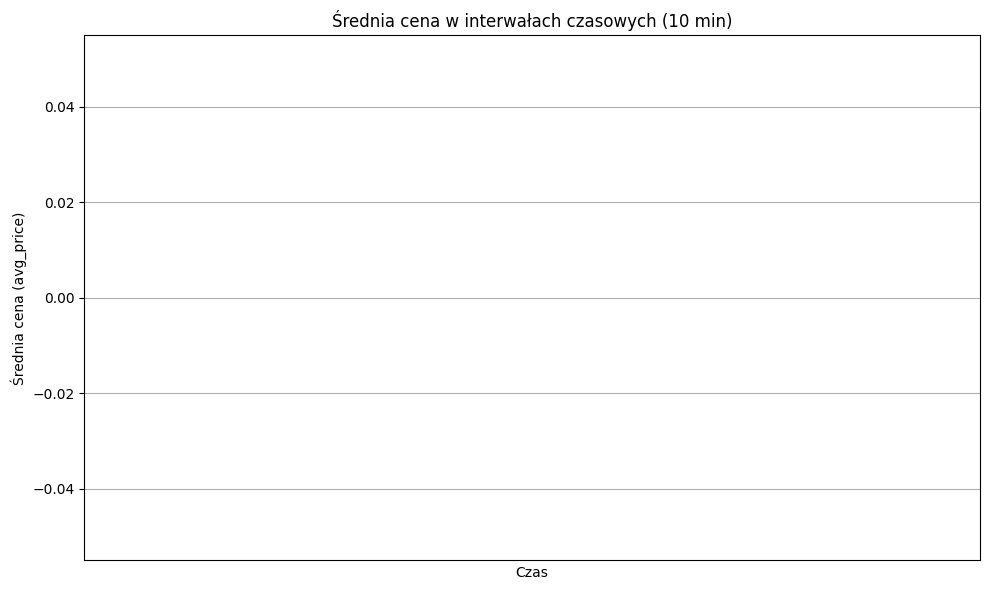

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

result_trades = client.sql.execute(query).result()

def convert_time_bucket_to_datetime(time_bucket):
    return datetime.utcfromtimestamp(time_bucket / 1000)

time_buckets = []
avg_prices = []

for row in result_trades:
    time_buckets.append(convert_time_bucket_to_datetime(row["time_bucket"]))
    avg_prices.append(row["avg_price"])

print(time_buckets)
# Tworzenie DataFrame
df = pd.DataFrame({"time_bucket": time_buckets, "avg_price": avg_prices})

plt.figure(figsize=(10, 6))
plt.plot(df["time_bucket"], df["avg_price"], marker='o')
plt.title("Średnia cena w interwałach czasowych (10 min)")
plt.xlabel("Czas")
plt.ylabel("Średnia cena (avg_price)")

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.xticks(time_buckets, rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

###  Top 10 transakcji o najwyższej cenie

In [59]:
query= """
    SELECT 
        time_unix AS transaction_time,
        price AS price,
        volume AS volume
    FROM trades
    WHERE product_id = 'BTC-USD'
    ORDER BY price DESC
    LIMIT 10;

    """
result_trades = client.sql.execute(query).result()

result_trades_dict = []
for row in result_trades:
    trade = {
        "transaction_time": row["transaction_time"],  
        "price": row["price"],
        "volume": row["volume"]
    }
    trade["transaction_time"] = datetime.utcfromtimestamp(trade["transaction_time"] / 1000).strftime('%Y-%m-%d %H:%M')
    result_trades_dict.append(trade)

df = pd.DataFrame(result_trades_dict)
print(df)

Empty DataFrame
Columns: []
Index: []


### Średnia cena transakcji w stosunku do godziny dnia

In [58]:
import pandas as pd
from datetime import datetime

query = """

SELECT 
    CAST((time_unix / 3600000) % 24 AS INT) AS hour_of_day,
    AVG(price) AS avg_price
FROM trades
WHERE product_id = 'BTC-USD'
GROUP BY hour_of_day
ORDER BY hour_of_day;

"""

result_trades = client.sql.execute(query).result()

result_trades_dict = []
for row in result_trades:
    trade = {
        "hour_of_day": row["hour_of_day"],
        "avg_price": row["avg_price"]
    }
    result_trades_dict.append(trade)

df = pd.DataFrame(result_trades_dict)
print(df)

plt.figure(figsize=(10, 6))
plt.plot(df['hour_of_day'], df['avg_price'], marker='o', linestyle='-', color='b')
plt.title('Średnia cena BTC w zależności od godziny dnia')
plt.xlabel('Godzina dnia')
plt.ylabel('Średnia cena')
plt.grid(True)
plt.xticks(range(24))  
plt.show()

Empty DataFrame
Columns: []
Index: []


KeyError: 'hour_of_day'

<Figure size 1000x600 with 0 Axes>

### Procentowy udział transakcji Buy vs Sell w ciągu ostatniej godziny

1737559415129


C:\Users\MEX\AppData\Local\Temp\ipykernel_23672\1324738827.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_timestamp = int(datetime.utcnow().timestamp() * 1000)


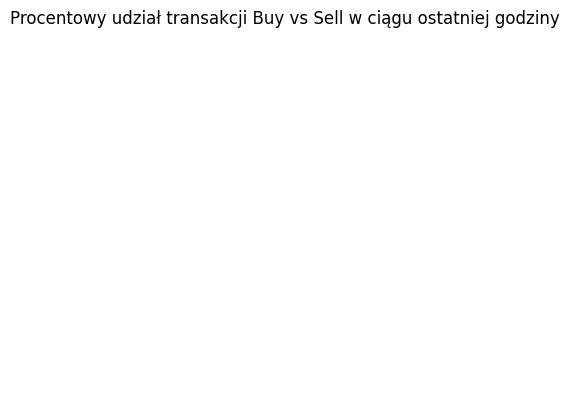

In [41]:
from collections import Counter

from datetime import datetime

current_timestamp = int(datetime.utcnow().timestamp() * 1000)
print(current_timestamp)

query = f"""
SELECT 
    side AS transaction_type,
    time_unix AS transaction_time
FROM trades
WHERE product_id = 'BTC-USD'
    AND time_unix > {current_timestamp - 3600000} 
ORDER BY transaction_time;

"""

result_trades = client.sql.execute(query).result()

transaction_types = [trade["transaction_type"] for trade in result_trades]

counter = Counter(transaction_types)

labels = counter.keys()
sizes = counter.values()

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal') 

plt.title("Procentowy udział transakcji Buy vs Sell w ciągu ostatniej godziny")
plt.show()

### SQL - Aggregated Trades

Mapa przechowywująca zagregowane dane na temat dwóch kursów: 
* BTC-USD
* ETH-USD

In [42]:
client.sql.execute("""
CREATE OR REPLACE MAPPING aggregated_trades (
    product_id VARCHAR,
    average_price DOUBLE,
    total_volume DOUBLE,
    last_updated BIGINT
)
TYPE IMap
OPTIONS (
    'keyFormat' = 'varchar',
    'valueFormat' = 'json-flat'
)
""")

In [43]:

query = '''
SELECT 
    product_id,
    average_price,
    total_volume,
    last_updated
FROM aggregated_trades
ORDER BY last_updated DESC;
'''

result_trades = client.sql.execute(query).result()
result_trades_dict = []
for row in result_trades:
    trade = {
        "product_id": row["product_id"],  
        "average_price": row["average_price"],
        "average_price": row["average_price"]
    }
    trade["last_updated"] =        datetime.fromtimestamp(row["last_updated"] / 1000).strftime('%Y-%m-%d %H:%M:%S')  # Konwersja timestamp na czytelny format

    result_trades_dict.append(trade)

df = pd.DataFrame(result_trades_dict)
print(df)

Empty DataFrame
Columns: []
Index: []


### Cachowanie

In [61]:
from hazelcast.config import Config, NearCacheConfig

In [2]:
# config = Config()
# config.cluster_name = "dev"
# config.cluster_members = ["127.0.0.1:5701", "127.0.0.1:5702", "127.0.0.1:5703"]

# near_cache_config = NearCacheConfig()
# near_cache_config.time_to_live = 120 # czas życia wpisów w Near Cache
# near_cache_config.max_idle = 60 # maksymalny czas bezczynności

# config.near_caches = {
#     "cache-map": near_cache_config,
# }

# client = hazelcast.HazelcastClient(config)

In [4]:
import time

In [68]:
cache_map = client.get_map("cache-map").blocking()

cache_map.put("key", "value")

start_time = time.perf_counter()
print(cache_map.get("key")) # odczyt z serwera
elapsed_time_1 = (time.perf_counter() - start_time) * 1000

start_time = time.perf_counter()
print(cache_map.get("key")) # odczyt z Near Cache
elapsed_time_2 = (time.perf_counter() - start_time) * 1000

print(f"Czas odczytu z serwera: {elapsed_time_1:.2f} ms")
print(f"Czas odczytu z cache: {elapsed_time_2:.2f} ms")

value
value
Czas odczytu z serwera: 1.95 ms
Czas odczytu z cache: 0.14 ms


In [ ]:
client.shutdown()

### Przetwarzanie po stronie klienta

In [8]:
from hazelcast.aggregator import count, number_avg, max_by, double_avg
from hazelcast.predicate import greater_or_equal, less_or_equal

In [11]:
trades = client.get_map("coinbase_trades").blocking()

client.sql.execute("""
        CREATE OR REPLACE MAPPING trades (
            trade_id VARCHAR,
            product_id VARCHAR,
            price DOUBLE,
            volume DOUBLE,
            time_iso VARCHAR,
            time_unix BIGINT,
            side VARCHAR
        )
        TYPE IMap
        OPTIONS (
            'keyFormat' = 'varchar',
            'valueFormat' = 'json-flat'
        )
        """)

In [ ]:
# Problem z wykonaniem - nawet jeśli przejdzie to jest to strasznie dużo danych, a na kliencie przelicza się wolniej - dalej preferuję wersję z syntetycznym przykładem

trades_count = trades.aggregate(count())
print("Aktualnie jest {} wybranych rekordów".format(trades_count))

trades_high = trades.aggregate(count(), greater_or_equal("price", 103800))
print("Z tego {} jest powyżej ceny 103800".format(trades_high))

average_price = trades.aggregate(double_avg("price"))
print("Średnia cena wynosi {:.2f}".format(average_price))

top_volume = trades.aggregate(max_by("volume"))
print("Największa wymiana była na {} jednostek".format(top_volume))

In [13]:
people = client.get_map("people").blocking()

people.put_all(
    {
        "Philip": 46,
        "Elizabeth": 44,
        "Henry": 13,
        "Paige": 15,
        "Pola": 89,
        "Marthin": 9,
        "Colin": 62,
        "Brad": 29,
    }
)

people_count = people.aggregate(count())
print("Aktualnie jest {} osób".format(people_count))

children_count = people.aggregate(count(), less_or_equal("this", 18))
print("Z tego {} jest jeszcze dziećmi".format(children_count))

average_age = people.aggregate(number_avg())
print("Średnia wieku wynosi {:.2f}".format(average_age))

eldest_person = people.aggregate(max_by("this"))
print("Najstarsza osoba to {}, ma {} lat".format(eldest_person.key, eldest_person.value))

Aktualnie jest 8 osób
Z tego 3 jest jeszcze dziećmi
Średnia wieku wynosi 38.38
Najstarsza osoba to Pola, ma 89 lat


In [10]:
client.shutdown()

### MultiMap

In [14]:
multi_map = client.get_multi_map("multi-map").blocking()

In [16]:
multi_map.put("key1", 7)
multi_map.put("key2", 4)
multi_map.put("key1", 1)
multi_map.put("key1", 0)
multi_map.put("key3", 9)
multi_map.put("key2", 5)

value = multi_map.get("key1")
print("Otrzymane wartośi: ", value)

values = multi_map.values()
print("Wszystkie wartości: ", values)

for key, value in multi_map.entry_set():
    print(key, " -> ", value)


Otrzymane wartośi:  [0, 7, 1]
Wszystkie wartości:  [0, 7, 1, 5, 4, 9]
key1  ->  7
key1  ->  1
key1  ->  0
key2  ->  5
key2  ->  4
key3  ->  9


### RingBuffer

In [27]:
# Z Pythona nie można określić rozmiaru RingBuffera -> hazelcast.yaml, hazelcast.xml
rb = client.get_ringbuffer("ring-buffer").blocking()

print("Pojemność: ", rb.capacity())

sequence = rb.add("Item")
print("Wielkość: ", rb.size())

first_item = rb.read_one(sequence)
print("Pierwszy element to {}".format(first_item))

Pojemność:  10000
Wielkość:  10000
Pierwszy element to Item


### Map Listener

In [5]:
import time

In [2]:
my_map = client.get_map("listener-map").blocking()

In [9]:
def entry_added(event):
    print("Dodano pozycję o kluczu {} i wartości {}".format(event.key, event.value))

def entry_removed(event):
    print("Usunięto pozycję o kluczu {}".format(event.key))

def entry_updated(event):
    print("Zmieniono wartość pozycji o kluczu {} z {} na {}".format(event.key, event.old_value, event.value))



my_map.add_entry_listener(True, added_func=entry_added, removed_func=entry_removed, updated_func=entry_updated)

my_map.put("key", "value")
my_map.put("key", "new value")
my_map.remove("key")

time.sleep(5)

client.shutdown()


### Subskrypcja do Topic

In [44]:
import hazelcast
import time
import logging

logging.basicConfig(level=logging.DEBUG) 
logger = logging.getLogger(__name__)


def on_message(event):
    print("Got message:", event.message)
    print("Publish time:", event.publish_time)

client = hazelcast.HazelcastClient(
    cluster_name="dev",
    cluster_members=["127.0.0.1:5701", "127.0.0.1:5702", "127.0.0.1:5703"],
    connection_timeout=30000,  
    reconnect_mode='ON',  # Włączona ponowna próba połączenia - bez tego nie działa odbieranie topica 
)

# Inicjalizujemy klienta

topic = client.get_topic("topic").blocking()
topic.add_listener(on_message)

time.sleep(10)



DEBUG:hazelcast.reactor:Starting Reactor Thread
INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is STARTING
INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is STARTED
INFO:hazelcast.connection:Trying to connect to Address(host=127.0.0.1, port=5701)
DEBUG:hazelcast.reactor:Connected to Address(host=127.0.0.1, port=5701)
INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is CONNECTED
INFO:hazelcast.connection:Authenticated with server Address(host=172.20.0.2, port=5701):4d2a1c01-bd42-4b54-a4d4-6bb3819797df, server version: 5.5.0, local address: Address(host=127.0.0.1, port=53600)
DEBUG:hazelcast.cluster:Resetting the member list version
DEBUG:hazelcast.cluster:Handling new snapshot with membership version: 3, member string: 

Members [3] {
	Member [172.20.0.3]:5701 - 10045533-e3fa-41b8-a26f-08759e201d07
	Member [172.20.0.2]:5701 - 4d2a1c01-bd42-4b54-a4d4-6bb3819797df
	Member [172.20.0.4]:5701 - 19566e8f-c7d4-4fa9-80fd-3b2fd7a9b0ca
}

INFO:hazelcast.cluster:

Members [3] {
	Member [172.20.0.3]:

In [45]:
client.shutdown()

INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is SHUTTING_DOWN
DEBUG:hazelcast.connection:Connection(id=0, live=False, remote_address=Address(host=172.20.0.2, port=5701)) closed. Reason: Hazelcast client is shutting down
INFO:hazelcast.connection:Removed connection to Address(host=172.20.0.2, port=5701):4d2a1c01-bd42-4b54-a4d4-6bb3819797df, connection: Connection(id=0, live=False, remote_address=Address(host=172.20.0.2, port=5701))
INFO:hazelcast.lifecycle:HazelcastClient 5.5.0 is DISCONNECTED
DEBUG:hazelcast.invocation:Got exception for request OutboundMessage(message_type=256, correlation_id=15, retryable=True), error: Client is not active
DEBUG:hazelcast.connection:Connection(id=3, live=False, remote_address=None) closed. Reason: Failed to authenticate connection
DEBUG:hazelcast.connection:Destroying Connection(id=3, live=False, remote_address=None), but it has no remote address, hence nothing is removed from the connection dictionary
DEBUG:hazelcast.invocation:Got exception for re